In [ ]:
pip install pulp ortools gurobipy matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [ ]:
from pulp import *
from ortools.sat.python import cp_model
from gurobipy import *
import time
import random
import matplotlib.pyplot as plt

### 1D

In [ ]:
# Implementation using PuLP
from pulp import *

def solve_bin_packing_pulp(weights, bin_capacity, max_bins=None):
    """
    Solve bin packing problem using PuLP
    weights: list of item weights
    bin_capacity: capacity of each bin
    max_bins: maximum number of bins to use (optional)
    """
    n = len(weights)
    if max_bins is None:
        max_bins = n  # Worst case: one item per bin

    # Create the model
    prob = LpProblem("BinPacking", LpMinimize)

    # Decision variables
    # x[i][j] = 1 if item i is packed in bin j
    x = [[LpVariable(f"x_{i}_{j}", 0, 1, LpBinary)
          for j in range(max_bins)]
          for i in range(n)]

    # y[j] = 1 if bin j is used
    y = [LpVariable(f"y_{j}", 0, 1, LpBinary)
         for j in range(max_bins)]

    # Objective: Minimize number of bins used
    prob += lpSum(y)

    # Constraints
    # Each item must be packed exactly once
    for i in range(n):
        prob += lpSum(x[i][j] for j in range(max_bins)) == 1

    # Bin capacity constraints
    for j in range(max_bins):
        prob += lpSum(weights[i] * x[i][j] for i in range(n)) <= bin_capacity * y[j]

    # Solve the problem
    prob.solve()

    # Extract solution
    solution = []
    for j in range(max_bins):
        if value(y[j]) > 0.5:  # Account for numerical precision
            bin_items = []
            for i in range(n):
                if value(x[i][j]) > 0.5:
                    bin_items.append(i)
            solution.append(bin_items)

    return solution

# Implementation using Gurobi
from gurobipy import *

def solve_bin_packing_gurobi(weights, bin_capacity, max_bins=None):
    """
    Solve bin packing problem using Gurobi
    """
    n = len(weights)
    if max_bins is None:
        max_bins = n

    # Create model
    m = Model("BinPacking")

    # Decision variables
    x = m.addVars(n, max_bins, vtype=GRB.BINARY, name="x")
    y = m.addVars(max_bins, vtype=GRB.BINARY, name="y")

    # Objective
    m.setObjective(quicksum(y[j] for j in range(max_bins)), GRB.MINIMIZE)

    # Constraints
    # Each item must be packed exactly once
    for i in range(n):
        m.addConstr(quicksum(x[i,j] for j in range(max_bins)) == 1)

    # Bin capacity constraints
    for j in range(max_bins):
        m.addConstr(quicksum(weights[i] * x[i,j] for i in range(n)) <= bin_capacity * y[j])

    # Optimize
    m.optimize()

    # Extract solution
    solution = []
    for j in range(max_bins):
        if y[j].X > 0.5:
            bin_items = []
            for i in range(n):
                if x[i,j].X > 0.5:
                    bin_items.append(i)
            solution.append(bin_items)

    return solution

# Implementation using Google OR-Tools
from ortools.sat.python import cp_model

def solve_bin_packing_ortools(weights, bin_capacity, max_bins=None):
    """
    Solve bin packing problem using Google OR-Tools
    """
    n = len(weights)
    if max_bins is None:
        max_bins = n

    model = cp_model.CpModel()

    # Decision variables
    x = {}
    for i in range(n):
        for j in range(max_bins):
            x[i,j] = model.NewBoolVar(f'x_{i}_{j}')

    y = [model.NewBoolVar(f'y_{j}') for j in range(max_bins)]

    # Constraints
    # Each item must be packed exactly once
    for i in range(n):
        model.Add(sum(x[i,j] for j in range(max_bins)) == 1)

    # Bin capacity constraints
    for j in range(max_bins):
        model.Add(sum(weights[i] * x[i,j] for i in range(n)) <= bin_capacity * y[j])

    # Objective: minimize number of bins used
    model.Minimize(sum(y))

    # Solve
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        solution = []
        for j in range(max_bins):
            if solver.Value(y[j]) > 0:
                bin_items = []
                for i in range(n):
                    if solver.Value(x[i,j]) > 0:
                        bin_items.append(i)
                solution.append(bin_items)
        return solution
    else:
        return None



In [ ]:
# Example usage
def main():
    # Example problem
    weights = [4, 8, 1, 4, 2, 1, 3, 5, 7, 3]
    bin_capacity = 10

    print("Solving bin packing problem:")
    print(f"Items: {weights}")
    print(f"Bin capacity: {bin_capacity}")

    # Solve using PuLP
    print("\nPuLP Solution:")
    pulp_solution = solve_bin_packing_pulp(weights, bin_capacity)
    for i, bin_items in enumerate(pulp_solution):
        bin_weight = sum(weights[j] for j in bin_items)
        print(f"Bin {i + 1}: items {bin_items} (weight: {bin_weight})")

    # Solve using Gurobi (uncomment if Gurobi is installed)

    print("\nGurobi Solution:")
    gurobi_solution = solve_bin_packing_gurobi(weights, bin_capacity)
    for i, bin_items in enumerate(gurobi_solution):
        bin_weight = sum(weights[j] for j in bin_items)
        print(f"Bin {i + 1}: items {bin_items} (weight: {bin_weight})")

    # Solve using OR-Tools
    print("\nOR-Tools Solution:")
    ortools_solution = solve_bin_packing_ortools(weights, bin_capacity)
    if ortools_solution:
        for i, bin_items in enumerate(ortools_solution):
            bin_weight = sum(weights[j] for j in bin_items)
            print(f"Bin {i + 1}: items {bin_items} (weight: {bin_weight})")

if __name__ == "__main__":
    main()

Solving bin packing problem:
Items: [4, 8, 1, 4, 2, 1, 3, 5, 7, 3]
Bin capacity: 10

PuLP Solution:
Bin 1: items [0, 2, 3, 5] (weight: 10)
Bin 2: items [4, 7, 9] (weight: 10)
Bin 3: items [1] (weight: 8)
Bin 4: items [6, 8] (weight: 10)

Gurobi Solution:
Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 20 rows, 110 columns and 210 nonzeros
Model fingerprint: 0xf2543f43
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6.0000000
Presolve time: 0.00s
Presolved: 20 rows, 110 columns, 210 nonzeros
Variable types: 0 continuous, 110 integ

In [ ]:
def generate_problem(num_items: int) -> Tuple[List[int], int]:
    """Generate a random bin packing problem of specified size"""
    weights = [random.randint(1, 10) for _ in range(num_items)]
    bin_capacity = 20  # Fixed bin capacity
    return weights, bin_capacity

In [ ]:
problem_sizes = [5,10,15,20,25,30,35,40]
pulp_times = []
ortools_times = []
gurobi_times = []
for size in problem_sizes:
    print(size)
    weights, bin_capacity = generate_problem(size)

    # Benchmark PuLP
    start_time = time.time()
    pulp_solution = solve_bin_packing_pulp(weights, bin_capacity)
    end_time = time.time()-start_time
    pulp_times.append(end_time)

    # Benchmark OR-Tools
    start_time = time.time()
    ortools_solution = solve_bin_packing_ortools(weights, bin_capacity)
    end_time = time.time()-start_time
    ortools_times.append(end_time)

    # Benchmark Gurobi (uncomment if available)
    start_time = time.time()
    gurobi_solution = solve_bin_packing_gurobi(weights, bin_capacity)
    end_time = time.time()-start_time
    gurobi_times.append(end_time)

5
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 10 rows, 30 columns and 55 nonzeros
Model fingerprint: 0x09e305f5
Variable types: 0 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4.0000000
Presolve time: 0.00s
Presolved: 10 rows, 30 columns, 55 nonzeros
Variable types: 0 continuous, 30 integer (30 binary)

Root relaxation: objective 1.900000e+00, 18 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.90000    0    4    4.00000    1.90000  52.5%     -    0s


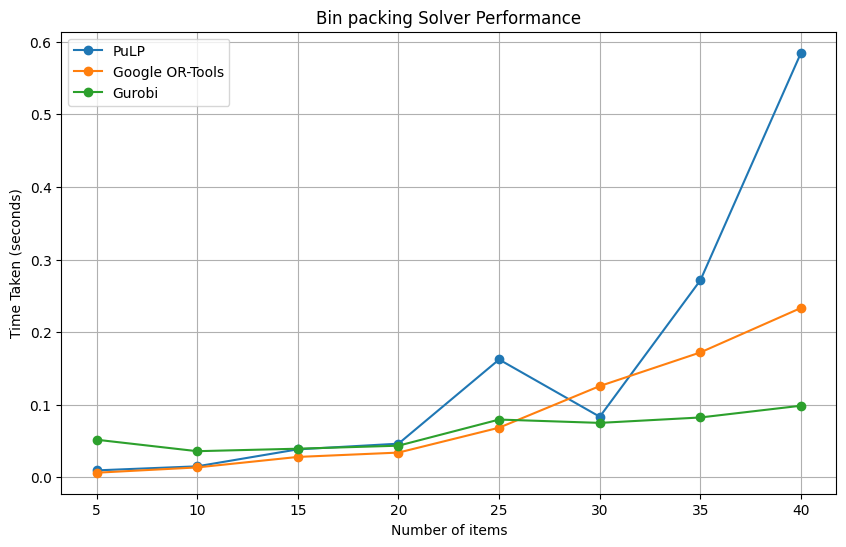

In [ ]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(problem_sizes, pulp_times, label="PuLP", marker="o")
plt.plot(problem_sizes, ortools_times, label="Google OR-Tools", marker="o")
plt.plot(problem_sizes, gurobi_times, label="Gurobi", marker="o")
plt.xlabel("Number of items")
plt.ylabel("Time Taken (seconds)")
plt.title("Bin packing Solver Performance")
plt.legend()
plt.grid()
plt.show()

In [ ]:
problem_sizes = [25,50,75,100,125,150,200,250,300]
pulp_times = []
ortools_times = []
gurobi_times = []
for size in problem_sizes:
    print(size)
    weights, bin_capacity = generate_problem(size)

    # Benchmark PuLP
    start_time = time.time()
    pulp_solution = solve_bin_packing_pulp(weights, bin_capacity)
    end_time = time.time()-start_time
    pulp_times.append(end_time)

    # Benchmark OR-Tools
    start_time = time.time()
    ortools_solution = solve_bin_packing_ortools(weights, bin_capacity)
    end_time = time.time()-start_time
    ortools_times.append(end_time)

    # Benchmark Gurobi (uncomment if available)
    # start_time = time.time()
    # gurobi_solution = solve_bin_packing_gurobi(weights, bin_capacity)
    # end_time = time.time()-start_time
    # gurobi_times.append(end_time)

25
50
75
100
125
150
200
250
300


In [ ]:
pulp_times

[0.045084238052368164,
 0.2647240161895752,
 10.059941053390503,
 5.576841831207275,
 21.014121294021606,
 28.546776056289673,
 65.68129134178162,
 103.68204545974731,
 749.5771369934082]

In [ ]:
ortools_times

[0.06033802032470703,
 0.37682342529296875,
 1.0599439144134521,
 2.7700226306915283,
 5.543425798416138,
 6.04899525642395,
 13.998495101928711,
 249.25061774253845,
 622.7769167423248]

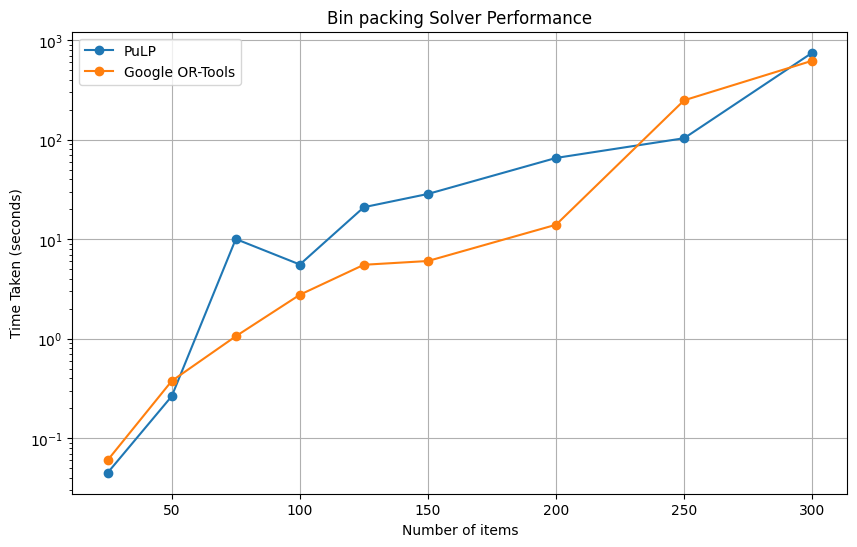

In [ ]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(problem_sizes, pulp_times, label="PuLP", marker="o")
plt.plot(problem_sizes, ortools_times, label="Google OR-Tools", marker="o")
# plt.plot(problem_sizes, gurobi_times, label="Gurobi", marker="o")
plt.xlabel("Number of items")
plt.ylabel("Time Taken (seconds)")
plt.title("Bin packing Solver Performance")
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

### 2D

Solving with PuLP...
PuLP solution uses 3 bins


<ipython-input-8-f2d96bcde75e>:203: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))


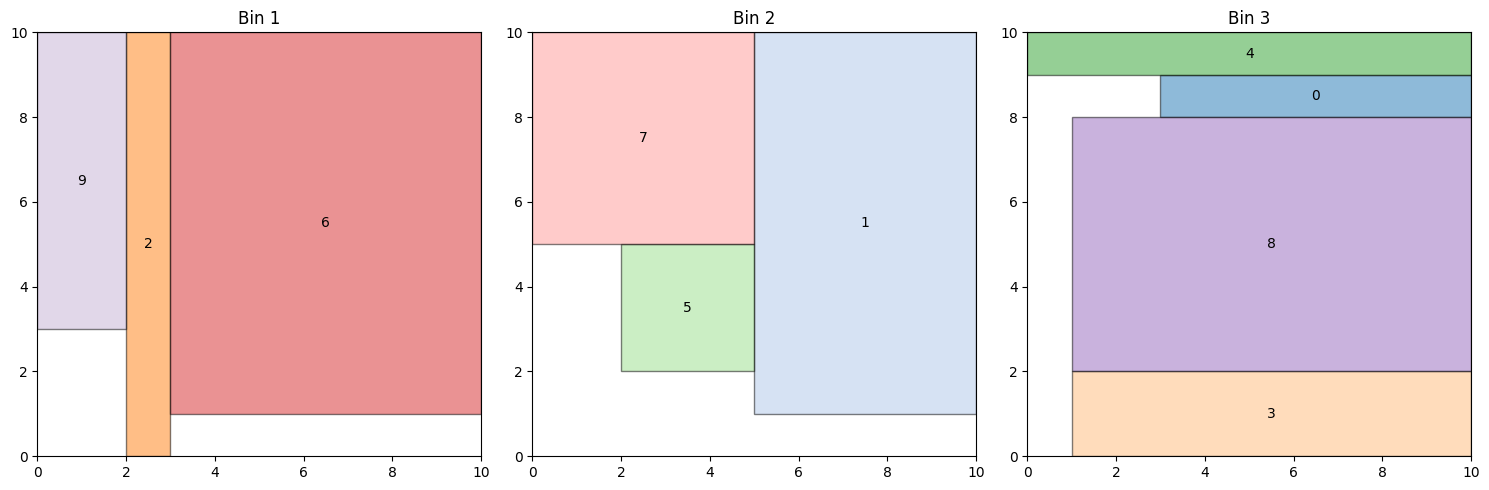


Solving with OR-Tools...
OR-Tools solution uses 3 bins


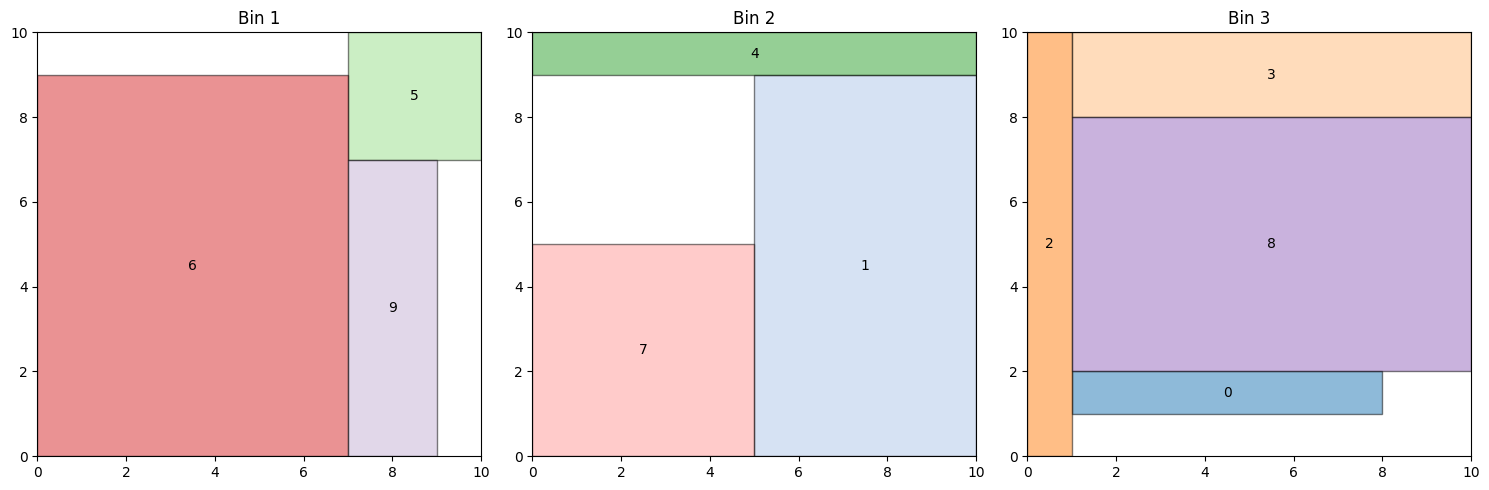

In [ ]:
import pulp
import numpy as np
from ortools.sat.python import cp_model
# from gurobipy import * # Uncomment if Gurobi is available
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from typing import List, Tuple, Dict

class Item:
    def __init__(self, width: int, height: int, id: int):
        self.width = width
        self.height = height
        self.id = id

    def __repr__(self):
        return f"Item({self.id}: {self.width}x{self.height})"

def solve_2d_bin_packing_pulp(items: List[Item], bin_width: int, bin_height: int, max_bins: int = None):
    """
    Solve 2D bin packing using PuLP
    """
    if max_bins is None:
        max_bins = len(items)

    n = len(items)
    prob = pulp.LpProblem("2D_BinPacking", pulp.LpMinimize)

    # Decision variables
    # x[i][b] = 1 if item i is placed in bin b
    x = pulp.LpVariable.dicts("item_to_bin",
                             ((i, b) for i in range(n) for b in range(max_bins)),
                             cat='Binary')

    # Position variables
    pos_x = pulp.LpVariable.dicts("pos_x",
                                 ((i, b) for i in range(n) for b in range(max_bins)),
                                 lowBound=0,
                                 upBound=bin_width)
    pos_y = pulp.LpVariable.dicts("pos_y",
                                 ((i, b) for i in range(n) for b in range(max_bins)),
                                 lowBound=0,
                                 upBound=bin_height)

    # Bin usage variables
    bin_used = pulp.LpVariable.dicts("bin_used",
                                    (b for b in range(max_bins)),
                                    cat='Binary')

    # Objective: Minimize number of bins used
    prob += pulp.lpSum(bin_used[b] for b in range(max_bins))

    # Each item must be in exactly one bin
    for i in range(n):
        prob += pulp.lpSum(x[i,b] for b in range(max_bins)) == 1

    # Items must fit within bin dimensions
    for i in range(n):
        for b in range(max_bins):
            prob += pos_x[i,b] + items[i].width * x[i,b] <= bin_width
            prob += pos_y[i,b] + items[i].height * x[i,b] <= bin_height

    # No overlap between items in the same bin
    M = max(bin_width, bin_height)
    for i in range(n):
        for j in range(i+1, n):
            for b in range(max_bins):
                # If both items are in the same bin
                overlap_vars = []
                # Item i is to the left of item j
                left = pulp.LpVariable(f"left_{i}_{j}_{b}", cat='Binary')
                overlap_vars.append(left)
                prob += pos_x[i,b] + items[i].width <= pos_x[j,b] + M * (1 - left)

                # Item i is to the right of item j
                right = pulp.LpVariable(f"right_{i}_{j}_{b}", cat='Binary')
                overlap_vars.append(right)
                prob += pos_x[j,b] + items[j].width <= pos_x[i,b] + M * (1 - right)

                # Item i is below item j
                below = pulp.LpVariable(f"below_{i}_{j}_{b}", cat='Binary')
                overlap_vars.append(below)
                prob += pos_y[i,b] + items[i].height <= pos_y[j,b] + M * (1 - below)

                # Item i is above item j
                above = pulp.LpVariable(f"above_{i}_{j}_{b}", cat='Binary')
                overlap_vars.append(above)
                prob += pos_y[j,b] + items[j].height <= pos_y[i,b] + M * (1 - above)

                # At least one of these must be true if both items are in the bin
                prob += pulp.lpSum(overlap_vars) >= x[i,b] + x[j,b] - 1

    # Link bin usage variables
    for b in range(max_bins):
        prob += pulp.lpSum(x[i,b] for i in range(n)) <= n * bin_used[b]

    # Solve
    prob.solve()

    # Extract solution
    solution = []
    for b in range(max_bins):
        if pulp.value(bin_used[b]) > 0.5:
            bin_items = []
            for i in range(n):
                if pulp.value(x[i,b]) > 0.5:
                    bin_items.append({
                        'item': items[i],
                        'x': int(pulp.value(pos_x[i,b])),
                        'y': int(pulp.value(pos_y[i,b]))
                    })
            solution.append(bin_items)

    return solution

def solve_2d_bin_packing_ortools(items: List[Item], bin_width: int, bin_height: int, max_bins: int = None):
    """
    Solve 2D bin packing using Google OR-Tools
    """
    if max_bins is None:
        max_bins = len(items)

    n = len(items)
    model = cp_model.CpModel()

    # Decision variables
    x = {}  # item to bin assignment
    pos_x = {}  # x position of items
    pos_y = {}  # y position of items

    for i in range(n):
        for b in range(max_bins):
            x[i,b] = model.NewBoolVar(f'x_{i}_{b}')
            pos_x[i,b] = model.NewIntVar(0, bin_width - items[i].width, f'pos_x_{i}_{b}')
            pos_y[i,b] = model.NewIntVar(0, bin_height - items[i].height, f'pos_y_{i}_{b}')

    bin_used = [model.NewBoolVar(f'bin_{b}') for b in range(max_bins)]

    # Each item must be in exactly one bin
    for i in range(n):
        model.Add(sum(x[i,b] for b in range(max_bins)) == 1)

    # Link bin usage to item placement
    for b in range(max_bins):
        model.Add(sum(x[i,b] for i in range(n)) <= n * bin_used[b])

    # No overlap constraints
    for i in range(n):
        for j in range(i+1, n):
            for b in range(max_bins):
                # If both items are in the same bin
                both_in_bin = model.NewBoolVar(f'both_{i}_{j}_{b}')
                model.Add(x[i,b] + x[j,b] == 2).OnlyEnforceIf(both_in_bin)
                model.Add(x[i,b] + x[j,b] < 2).OnlyEnforceIf(both_in_bin.Not())

                # No overlap constraints
                left = model.NewBoolVar(f'left_{i}_{j}_{b}')
                right = model.NewBoolVar(f'right_{i}_{j}_{b}')
                below = model.NewBoolVar(f'below_{i}_{j}_{b}')
                above = model.NewBoolVar(f'above_{i}_{j}_{b}')

                # At least one must be true if both items are in the bin
                model.Add(left + right + below + above >= 1).OnlyEnforceIf(both_in_bin)

                # Implement the actual constraints
                model.Add(pos_x[i,b] + items[i].width <= pos_x[j,b]).OnlyEnforceIf(left)
                model.Add(pos_x[j,b] + items[j].width <= pos_x[i,b]).OnlyEnforceIf(right)
                model.Add(pos_y[i,b] + items[i].height <= pos_y[j,b]).OnlyEnforceIf(below)
                model.Add(pos_y[j,b] + items[j].height <= pos_y[i,b]).OnlyEnforceIf(above)

    # Objective: minimize number of bins used
    model.Minimize(sum(bin_used))

    # Solve
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        solution = []
        for b in range(max_bins):
            if solver.Value(bin_used[b]):
                bin_items = []
                for i in range(n):
                    if solver.Value(x[i,b]):
                        bin_items.append({
                            'item': items[i],
                            'x': solver.Value(pos_x[i,b]),
                            'y': solver.Value(pos_y[i,b])
                        })
                solution.append(bin_items)
        return solution
    return None

def visualize_solution(solution: List[List[Dict]], bin_width: int, bin_height: int):
    """
    Visualize the 2D bin packing solution
    """
    num_bins = len(solution)
    fig, axs = plt.subplots(1, num_bins, figsize=(5*num_bins, 5))
    if num_bins == 1:
        axs = [axs]

    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))

    for bin_idx, bin_items in enumerate(solution):
        ax = axs[bin_idx]
        ax.set_xlim(0, bin_width)
        ax.set_ylim(0, bin_height)
        ax.set_title(f'Bin {bin_idx + 1}')

        for item_data in bin_items:
            item = item_data['item']
            x = item_data['x']
            y = item_data['y']

            rect = patches.Rectangle(
                (x, y), item.width, item.height,
                facecolor=colors[item.id % 20],
                edgecolor='black',
                alpha=0.5
            )
            ax.add_patch(rect)
            ax.text(x + item.width/2, y + item.height/2, str(item.id),
                   horizontalalignment='center',
                   verticalalignment='center')

    plt.tight_layout()
    plt.show()

def generate_random_items(num_items: int, min_size: int = 1, max_size: int = 10) -> List[Item]:
    """Generate random items for testing"""
    return [Item(
        width=random.randint(min_size, max_size),
        height=random.randint(min_size, max_size),
        id=i
    ) for i in range(num_items)]

def main():
    # Example usage
    # Generate random items
    # items = generate_random_items(10)
    bin_width = 10
    bin_height = 10

    print("Solving with PuLP...")
    pulp_solution = solve_2d_bin_packing_pulp(items, bin_width, bin_height)
    print(f"PuLP solution uses {len(pulp_solution)} bins")
    visualize_solution(pulp_solution, bin_width, bin_height)

    print("\nSolving with OR-Tools...")
    ortools_solution = solve_2d_bin_packing_ortools(items, bin_width, bin_height)
    print(f"OR-Tools solution uses {len(ortools_solution)} bins")
    visualize_solution(ortools_solution, bin_width, bin_height)

if __name__ == "__main__":
    main()

In [ ]:
problem_sizes = [5,10,15,20]
pulp_times=[]
ortools_times=[]
for size in problem_sizes:
  print(size)
  items = generate_random_items(size)
  bin_width = 50
  bin_height = 50

  # Benchmark PuLP
  start_time = time.time()
  pulp_solution = solve_2d_bin_packing_pulp(items, bin_width, bin_height)
  end_time = time.time()-start_time
  pulp_times.append(end_time)

  # Benchmark OR-Tools
  start_time = time.time()
  ortools_solution = solve_2d_bin_packing_ortools(items, bin_width, bin_height)
  end_time = time.time()-start_time
  ortools_times.append(end_time)

  # pulp_solution = solve_2d_bin_packing_pulp(items, bin_width, bin_height)
  # print(f"PuLP solution uses {len(pulp_solution)} bins")
  # visualize_solution(pulp_solution, bin_width, bin_height)

  # print("\nSolving with OR-Tools...")
  # ortools_solution = solve_2d_bin_packing_ortools(items, bin_width, bin_height)
  # print(f"OR-Tools solution uses {len(ortools_solution)} bins")
  # visualize_solution(ortools_solution, bin_width, bin_height)


5
10
15
20


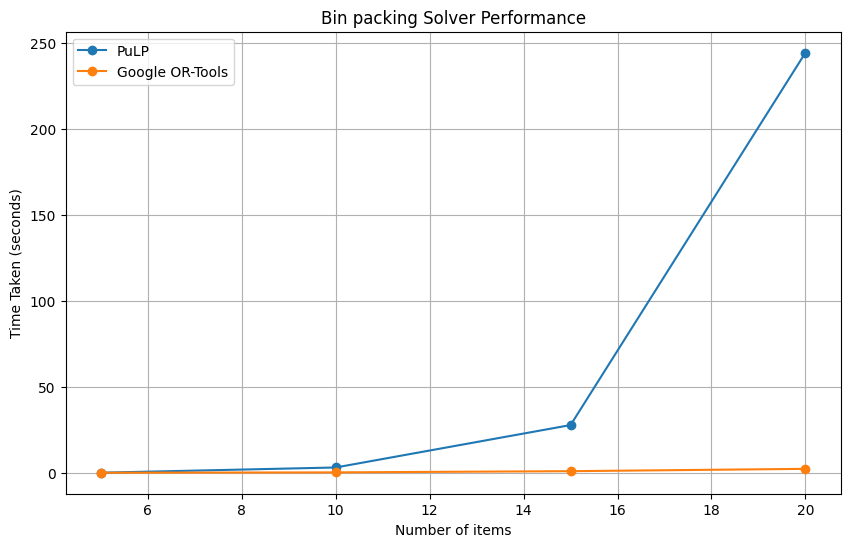

In [ ]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(problem_sizes, pulp_times, label="PuLP", marker="o")
plt.plot(problem_sizes, ortools_times, label="Google OR-Tools", marker="o")
# plt.plot(problem_sizes, gurobi_times, label="Gurobi", marker="o")
plt.xlabel("Number of items")
plt.ylabel("Time Taken (seconds)")
plt.title("Bin packing Solver Performance")
plt.legend()
plt.grid()
plt.show()

### 3D

Items to pack:
Item3D(0: 4x3x2) - Volume: 24
Item3D(1: 4x2x3) - Volume: 24
Item3D(2: 1x3x2) - Volume: 6
Item3D(3: 1x3x3) - Volume: 9
Item3D(4: 5x3x4) - Volume: 60
Item3D(5: 1x2x4) - Volume: 8
Item3D(6: 3x1x2) - Volume: 6
Item3D(7: 5x4x2) - Volume: 40
Item3D(8: 1x4x5) - Volume: 20
Item3D(9: 4x3x2) - Volume: 24
Item3D(10: 1x3x1) - Volume: 3
Item3D(11: 2x2x2) - Volume: 8

Solving with PuLP...
PuLP solution uses 1 bins


<ipython-input-3-d8a2f7840c0e>:237: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))


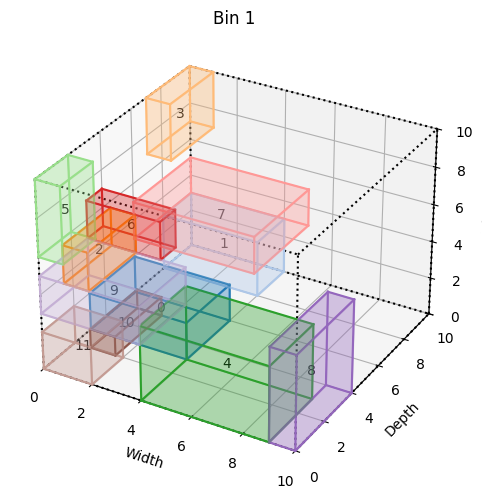


Solving with OR-Tools...
OR-Tools solution uses 1 bins


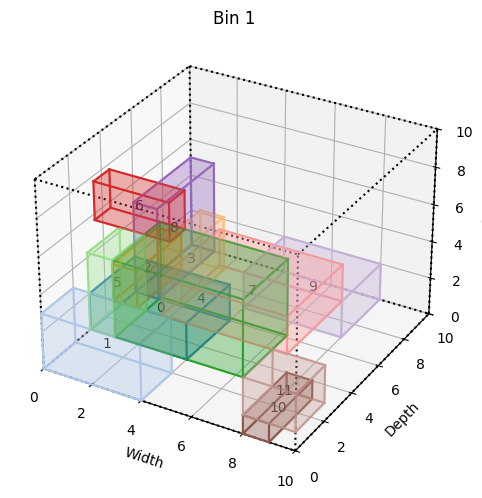

In [ ]:
import pulp
import numpy as np
from ortools.sat.python import cp_model
# from gurobipy import * # Uncomment if Gurobi is available
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d import Axes3D
import random
from typing import List, Tuple, Dict

class Item3D:
    def __init__(self, width: int, height: int, depth: int, id: int):
        self.width = width
        self.height = height
        self.depth = depth
        self.id = id
        self.volume = width * height * depth

    def __repr__(self):
        return f"Item3D({self.id}: {self.width}x{self.height}x{self.depth})"

def solve_3d_bin_packing_pulp(items: List[Item3D], bin_width: int, bin_height: int, bin_depth: int, max_bins: int = None):
    """
    Solve 3D bin packing using PuLP
    """
    if max_bins is None:
        max_bins = len(items)

    n = len(items)
    prob = pulp.LpProblem("3D_BinPacking", pulp.LpMinimize)

    # Decision variables
    # x[i][b] = 1 if item i is placed in bin b
    x = pulp.LpVariable.dicts("item_to_bin",
                             ((i, b) for i in range(n) for b in range(max_bins)),
                             cat='Binary')

    # Position variables
    pos_x = pulp.LpVariable.dicts("pos_x",
                                 ((i, b) for i in range(n) for b in range(max_bins)),
                                 lowBound=0,
                                 upBound=bin_width)
    pos_y = pulp.LpVariable.dicts("pos_y",
                                 ((i, b) for i in range(n) for b in range(max_bins)),
                                 lowBound=0,
                                 upBound=bin_height)
    pos_z = pulp.LpVariable.dicts("pos_z",
                                 ((i, b) for i in range(n) for b in range(max_bins)),
                                 lowBound=0,
                                 upBound=bin_depth)

    # Bin usage variables
    bin_used = pulp.LpVariable.dicts("bin_used",
                                    (b for b in range(max_bins)),
                                    cat='Binary')

    # Objective: Minimize number of bins used
    prob += pulp.lpSum(bin_used[b] for b in range(max_bins))

    # Each item must be in exactly one bin
    for i in range(n):
        prob += pulp.lpSum(x[i,b] for b in range(max_bins)) == 1

    # Items must fit within bin dimensions
    for i in range(n):
        for b in range(max_bins):
            prob += pos_x[i,b] + items[i].width * x[i,b] <= bin_width
            prob += pos_y[i,b] + items[i].height * x[i,b] <= bin_height
            prob += pos_z[i,b] + items[i].depth * x[i,b] <= bin_depth

    # No overlap between items in the same bin
    M = max(bin_width, bin_height, bin_depth)
    for i in range(n):
        for j in range(i+1, n):
            for b in range(max_bins):
                # If both items are in the same bin
                overlap_vars = []

                # Item i is to the left of item j
                left = pulp.LpVariable(f"left_{i}_{j}_{b}", cat='Binary')
                overlap_vars.append(left)
                prob += pos_x[i,b] + items[i].width <= pos_x[j,b] + M * (1 - left)

                # Item i is to the right of item j
                right = pulp.LpVariable(f"right_{i}_{j}_{b}", cat='Binary')
                overlap_vars.append(right)
                prob += pos_x[j,b] + items[j].width <= pos_x[i,b] + M * (1 - right)

                # Item i is below item j
                below = pulp.LpVariable(f"below_{i}_{j}_{b}", cat='Binary')
                overlap_vars.append(below)
                prob += pos_y[i,b] + items[i].height <= pos_y[j,b] + M * (1 - below)

                # Item i is above item j
                above = pulp.LpVariable(f"above_{i}_{j}_{b}", cat='Binary')
                overlap_vars.append(above)
                prob += pos_y[j,b] + items[j].height <= pos_y[i,b] + M * (1 - above)

                # Item i is behind item j
                behind = pulp.LpVariable(f"behind_{i}_{j}_{b}", cat='Binary')
                overlap_vars.append(behind)
                prob += pos_z[i,b] + items[i].depth <= pos_z[j,b] + M * (1 - behind)

                # Item i is in front of item j
                front = pulp.LpVariable(f"front_{i}_{j}_{b}", cat='Binary')
                overlap_vars.append(front)
                prob += pos_z[j,b] + items[j].depth <= pos_z[i,b] + M * (1 - front)

                # At least one of these must be true if both items are in the bin
                prob += pulp.lpSum(overlap_vars) >= x[i,b] + x[j,b] - 1

    # Link bin usage variables
    for b in range(max_bins):
        prob += pulp.lpSum(x[i,b] for i in range(n)) <= n * bin_used[b]

    # Symmetry breaking constraints (optional)
    for b in range(1, max_bins):
        prob += bin_used[b] <= bin_used[b-1]

    # Solve
    prob.solve()

    # Extract solution
    solution = []
    for b in range(max_bins):
        if pulp.value(bin_used[b]) > 0.5:
            bin_items = []
            for i in range(n):
                if pulp.value(x[i,b]) > 0.5:
                    bin_items.append({
                        'item': items[i],
                        'x': int(pulp.value(pos_x[i,b])),
                        'y': int(pulp.value(pos_y[i,b])),
                        'z': int(pulp.value(pos_z[i,b]))
                    })
            solution.append(bin_items)

    return solution

def solve_3d_bin_packing_ortools(items: List[Item3D], bin_width: int, bin_height: int, bin_depth: int, max_bins: int = None):
    """
    Solve 3D bin packing using Google OR-Tools
    """
    if max_bins is None:
        max_bins = len(items)

    n = len(items)
    model = cp_model.CpModel()

    # Decision variables
    x = {}  # item to bin assignment
    pos_x = {}  # x position of items
    pos_y = {}  # y position of items
    pos_z = {}  # z position of items

    for i in range(n):
        for b in range(max_bins):
            x[i,b] = model.NewBoolVar(f'x_{i}_{b}')
            pos_x[i,b] = model.NewIntVar(0, bin_width - items[i].width, f'pos_x_{i}_{b}')
            pos_y[i,b] = model.NewIntVar(0, bin_height - items[i].height, f'pos_y_{i}_{b}')
            pos_z[i,b] = model.NewIntVar(0, bin_depth - items[i].depth, f'pos_z_{i}_{b}')

    bin_used = [model.NewBoolVar(f'bin_{b}') for b in range(max_bins)]

    # Each item must be in exactly one bin
    for i in range(n):
        model.Add(sum(x[i,b] for b in range(max_bins)) == 1)

    # Link bin usage to item placement
    for b in range(max_bins):
        model.Add(sum(x[i,b] for i in range(n)) <= n * bin_used[b])

    # No overlap constraints
    for i in range(n):
        for j in range(i+1, n):
            for b in range(max_bins):
                # If both items are in the same bin
                both_in_bin = model.NewBoolVar(f'both_{i}_{j}_{b}')
                model.Add(x[i,b] + x[j,b] == 2).OnlyEnforceIf(both_in_bin)
                model.Add(x[i,b] + x[j,b] < 2).OnlyEnforceIf(both_in_bin.Not())

                # No overlap constraints using disjunction
                left = model.NewBoolVar(f'left_{i}_{j}_{b}')
                right = model.NewBoolVar(f'right_{i}_{j}_{b}')
                below = model.NewBoolVar(f'below_{i}_{j}_{b}')
                above = model.NewBoolVar(f'above_{i}_{j}_{b}')
                behind = model.NewBoolVar(f'behind_{i}_{j}_{b}')
                front = model.NewBoolVar(f'front_{i}_{j}_{b}')

                # At least one must be true if both items are in the bin
                model.Add(left + right + below + above + behind + front >= 1).OnlyEnforceIf(both_in_bin)

                # Implement the actual constraints
                model.Add(pos_x[i,b] + items[i].width <= pos_x[j,b]).OnlyEnforceIf(left)
                model.Add(pos_x[j,b] + items[j].width <= pos_x[i,b]).OnlyEnforceIf(right)
                model.Add(pos_y[i,b] + items[i].height <= pos_y[j,b]).OnlyEnforceIf(below)
                model.Add(pos_y[j,b] + items[j].height <= pos_y[i,b]).OnlyEnforceIf(above)
                model.Add(pos_z[i,b] + items[i].depth <= pos_z[j,b]).OnlyEnforceIf(behind)
                model.Add(pos_z[j,b] + items[j].depth <= pos_z[i,b]).OnlyEnforceIf(front)

    # Symmetry breaking constraints (optional)
    for b in range(1, max_bins):
        model.Add(bin_used[b] <= bin_used[b-1])

    # Objective: minimize number of bins used
    model.Minimize(sum(bin_used))

    # Solve
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 300  # Timeout after 5 minutes
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        solution = []
        for b in range(max_bins):
            if solver.Value(bin_used[b]):
                bin_items = []
                for i in range(n):
                    if solver.Value(x[i,b]):
                        bin_items.append({
                            'item': items[i],
                            'x': solver.Value(pos_x[i,b]),
                            'y': solver.Value(pos_y[i,b]),
                            'z': solver.Value(pos_z[i,b])
                        })
                solution.append(bin_items)
        return solution
    return None

def visualize_3d_solution(solution: List[List[Dict]], bin_width: int, bin_height: int, bin_depth: int):
    """
    Visualize the 3D bin packing solution
    """
    num_bins = len(solution)
    fig = plt.figure(figsize=(5*num_bins, 5))

    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))

    for bin_idx, bin_items in enumerate(solution):
        ax = fig.add_subplot(1, num_bins, bin_idx + 1, projection='3d')
        ax.set_xlim(0, bin_width)
        ax.set_ylim(0, bin_height)
        ax.set_zlim(0, bin_depth)
        ax.set_title(f'Bin {bin_idx + 1}')
        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')

        # Draw bin edges
        for s, e in [
            ((0, 0, 0), (bin_width, 0, 0)),
            ((0, 0, 0), (0, bin_height, 0)),
            ((0, 0, 0), (0, 0, bin_depth)),
            ((bin_width, 0, 0), (bin_width, bin_height, 0)),
            ((bin_width, 0, 0), (bin_width, 0, bin_depth)),
            ((0, bin_height, 0), (bin_width, bin_height, 0)),
            ((0, bin_height, 0), (0, bin_height, bin_depth)),
            ((0, 0, bin_depth), (bin_width, 0, bin_depth)),
            ((0, 0, bin_depth), (0, bin_height, bin_depth)),
            ((bin_width, bin_height, 0), (bin_width, bin_height, bin_depth)),
            ((bin_width, 0, bin_depth), (bin_width, bin_height, bin_depth)),
            ((0, bin_height, bin_depth), (bin_width, bin_height, bin_depth))
        ]:
            ax.plot3D(*zip(s, e), color='black', linestyle=':')

        for item_data in bin_items:
            item = item_data['item']
            x = item_data['x']
            y = item_data['y']
            z = item_data['z']

            color = colors[item.id % 20]

            # Create 3D cuboid (draw the 12 edges)
            for s, e in [
                ((x, y, z), (x + item.width, y, z)),
                ((x, y, z), (x, y + item.height, z)),
                ((x, y, z), (x, y, z + item.depth)),
                ((x + item.width, y, z), (x + item.width, y + item.height, z)),
                ((x + item.width, y, z), (x + item.width, y, z + item.depth)),
                ((x, y + item.height, z), (x + item.width, y + item.height, z)),
                ((x, y + item.height, z), (x, y + item.height, z + item.depth)),
                ((x, y, z + item.depth), (x + item.width, y, z + item.depth)),
                ((x, y, z + item.depth), (x, y + item.height, z + item.depth)),
                ((x + item.width, y + item.height, z), (x + item.width, y + item.height, z + item.depth)),
                ((x + item.width, y, z + item.depth), (x + item.width, y + item.height, z + item.depth)),
                ((x, y + item.height, z + item.depth), (x + item.width, y + item.height, z + item.depth))
            ]:
                ax.plot3D(*zip(s, e), color=color)

            # Draw semi-transparent faces
            for face in [
                [(x, y, z), (x + item.width, y, z), (x + item.width, y + item.height, z), (x, y + item.height, z)],  # bottom
                [(x, y, z + item.depth), (x + item.width, y, z + item.depth), (x + item.width, y + item.height, z + item.depth), (x, y + item.height, z + item.depth)],  # top
                [(x, y, z), (x, y, z + item.depth), (x, y + item.height, z + item.depth), (x, y + item.height, z)],  # left
                [(x + item.width, y, z), (x + item.width, y, z + item.depth), (x + item.width, y + item.height, z + item.depth), (x + item.width, y + item.height, z)],  # right
                [(x, y, z), (x + item.width, y, z), (x + item.width, y, z + item.depth), (x, y, z + item.depth)],  # front
                [(x, y + item.height, z), (x + item.width, y + item.height, z), (x + item.width, y + item.height, z + item.depth), (x, y + item.height, z + item.depth)]  # back
            ]:
                poly = plt.Polygon([(p[0], p[2]) for p in face], alpha=0.2, color=color)
                ax.add_collection3d(art3d.Poly3DCollection([face], alpha=0.2, color=color))

            # Add item ID at center
            ax.text(x + item.width/2, y + item.height/2, z + item.depth/2,
                   str(item.id),
                   horizontalalignment='center',
                   verticalalignment='center')

    plt.tight_layout()
    plt.show()

def generate_random_items_3d(num_items: int, min_size: int = 1, max_size: int = 5) -> List[Item3D]:
    """Generate random 3D items for testing"""
    return [Item3D(
        width=random.randint(min_size, max_size),
        height=random.randint(min_size, max_size),
        depth=random.randint(min_size, max_size),
        id=i
    ) for i in range(num_items)]

def main():
    # Example usage
    items = generate_random_items_3d(12)
    bin_width = 10
    bin_height = 10
    bin_depth = 10

    print("Items to pack:")
    for item in items:
        print(f"{item} - Volume: {item.volume}")

    print("\nSolving with PuLP...")
    pulp_solution = solve_3d_bin_packing_pulp(items, bin_width, bin_height, bin_depth)
    if pulp_solution:
        print(f"PuLP solution uses {len(pulp_solution)} bins")
        visualize_3d_solution(pulp_solution, bin_width, bin_height, bin_depth)
    else:
        print("PuLP couldn't find a solution")

    print("\nSolving with OR-Tools...")
    ortools_solution = solve_3d_bin_packing_ortools(items, bin_width, bin_height, bin_depth)
    if ortools_solution:
        print(f"OR-Tools solution uses {len(ortools_solution)} bins")
        visualize_3d_solution(ortools_solution, bin_width, bin_height, bin_depth)
    else:
        print("OR-Tools couldn't find a solution")

if __name__ == "__main__":
    main()

In [ ]:
problem_sizes = [5,10,15,20]
pulp_times=[]
ortools_times=[]
for size in problem_sizes:
  print(size)
  items = generate_random_items_3d(size)
  bin_width = 20
  bin_height = 20
  bin_depth = 20

  # Benchmark PuLP
  start_time = time.time()
  pulp_solution = solve_3d_bin_packing_pulp(items, bin_width, bin_height, bin_depth)
  end_time = time.time()-start_time
  pulp_times.append(end_time)

  # Benchmark OR-Tools
  start_time = time.time()
  ortools_solution = solve_3d_bin_packing_ortools(items, bin_width, bin_height, bin_depth)
  end_time = time.time()-start_time
  ortools_times.append(end_time)

  # pulp_solution = solve_2d_bin_packing_pulp(items, bin_width, bin_height)
  # print(f"PuLP solution uses {len(pulp_solution)} bins")
  # visualize_solution(pulp_solution, bin_width, bin_height)

  # print("\nSolving with OR-Tools...")
  # ortools_solution = solve_2d_bin_packing_ortools(items, bin_width, bin_height)
  # print(f"OR-Tools solution uses {len(ortools_solution)} bins")
  # visualize_solution(ortools_solution, bin_width, bin_height)


5
10
15
20


In [ ]:
problem_sizes = [25,30,35,40]
for size in problem_sizes:
  print(size)
  items = generate_random_items_3d(size)
  bin_width = 20
  bin_height = 20
  bin_depth = 20

  # Benchmark PuLP
  start_time = time.time()
  pulp_solution = solve_3d_bin_packing_pulp(items, bin_width, bin_height, bin_depth)
  end_time = time.time()-start_time
  pulp_times.append(end_time)

  # Benchmark OR-Tools
  start_time = time.time()
  ortools_solution = solve_3d_bin_packing_ortools(items, bin_width, bin_height, bin_depth)
  end_time = time.time()-start_time
  ortools_times.append(end_time)

  # pulp_solution = solve_2d_bin_packing_pulp(items, bin_width, bin_height)
  # print(f"PuLP solution uses {len(pulp_solution)} bins")
  # visualize_solution(pulp_solution, bin_width, bin_height)

  # print("\nSolving with OR-Tools...")
  # ortools_solution = solve_2d_bin_packing_ortools(items, bin_width, bin_height)
  # print(f"OR-Tools solution uses {len(ortools_solution)} bins")
  # visualize_solution(ortools_solution, bin_width, bin_height)


25
30
35
40


In [ ]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(problem_sizes, pulp_times, label="PuLP", marker="o")
plt.plot(problem_sizes, ortools_times, label="Google OR-Tools", marker="o")
# plt.plot(problem_sizes, gurobi_times, label="Gurobi", marker="o")
plt.xlabel("Number of items")
plt.ylabel("Time Taken (seconds)")
plt.title("Bin packing Solver Performance")
plt.legend()
plt.grid()
plt.show()

# Heuristics

Running Bottom-Left Fill algorithm...
Bottom-Left Fill: 4 bins


<ipython-input-4-114621ec9bf7>:215: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))


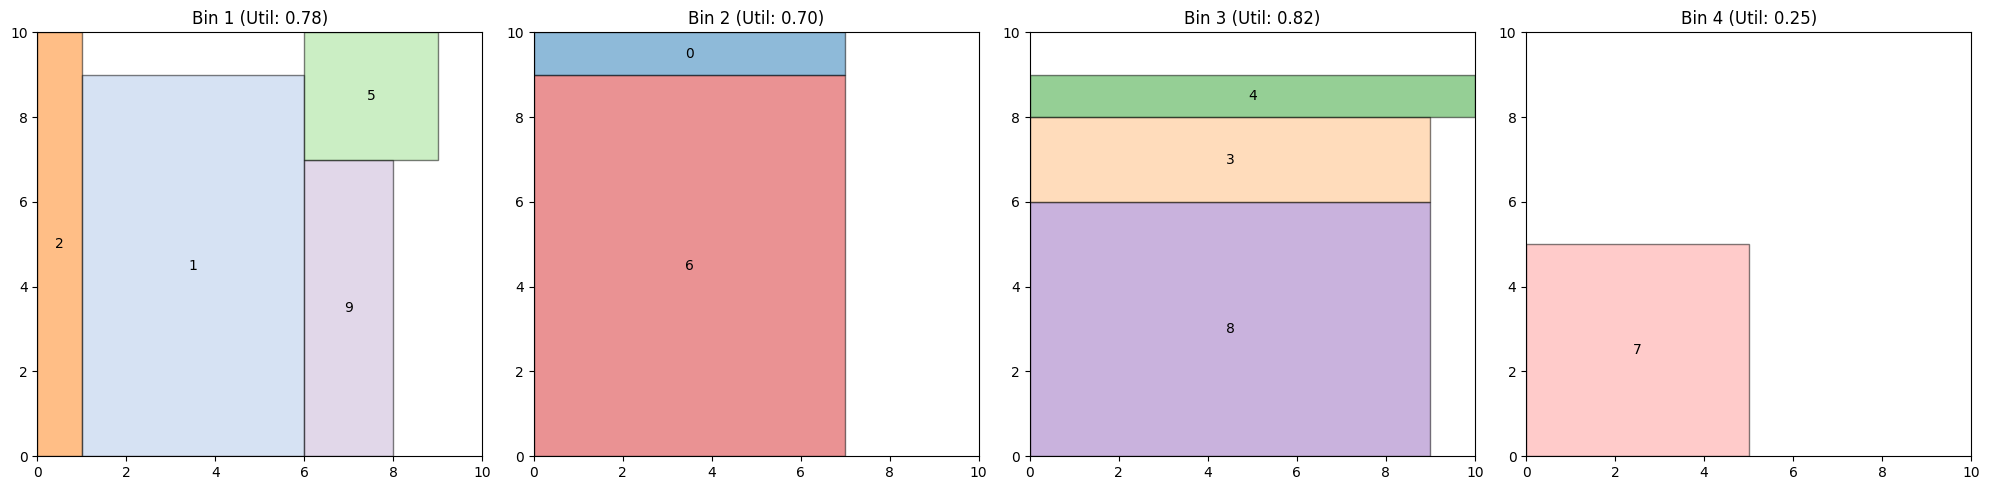


Running Simulated Annealing...
Simulated Annealing: 3 bins


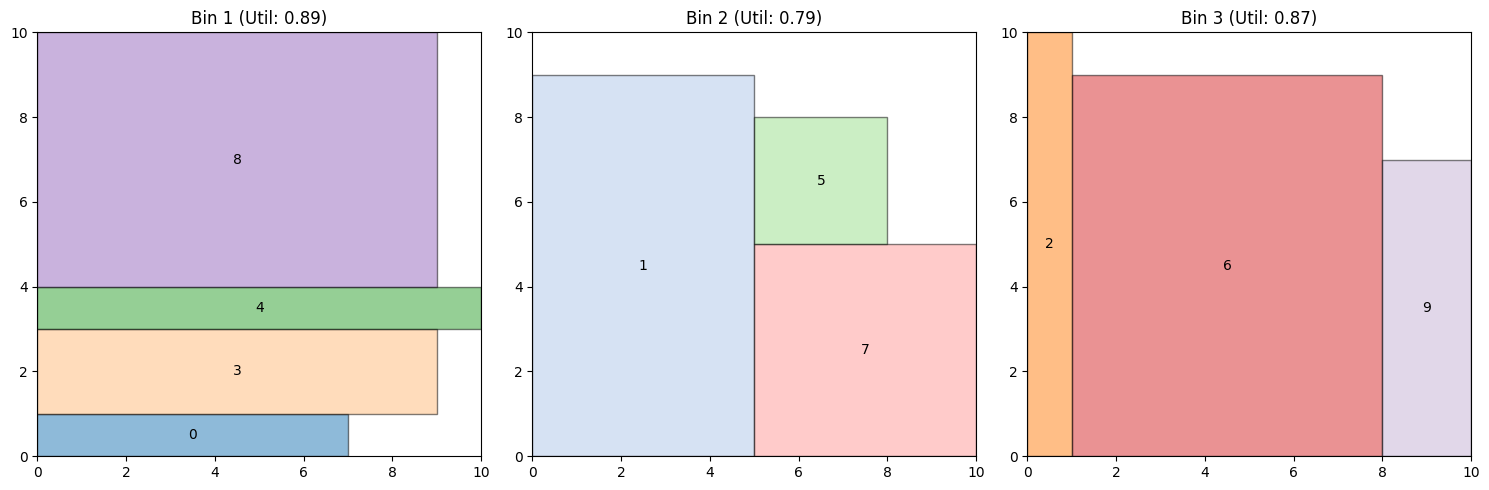

[Item(0: 7x1), Item(1: 5x9), Item(2: 1x10), Item(3: 9x2), Item(4: 10x1), Item(5: 3x3), Item(6: 7x9), Item(7: 5x5), Item(8: 9x6), Item(9: 2x7)]


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import List, Tuple, Dict
import time

class Item:
    def __init__(self, width: int, height: int, id: int):
        self.width = width
        self.height = height
        self.id = id
        self.area = width * height

    def __repr__(self):
        return f"Item({self.id}: {self.width}x{self.height})"

class Bin:
    def __init__(self, width: int, height: int, id: int):
        self.width = width
        self.height = height
        self.id = id
        self.items = []
        # Representation of the bin as a grid (0 = empty, 1 = occupied)
        self.grid = np.zeros((height, width), dtype=int)

    def can_place(self, item: Item, x: int, y: int) -> bool:
        """Check if an item can be placed at position (x, y)"""
        if x + item.width > self.width or y + item.height > self.height:
            return False

        # Check if the space is empty
        for i in range(item.height):
            for j in range(item.width):
                if self.grid[y + i, x + j] == 1:
                    return False
        return True

    def place_item(self, item: Item, x: int, y: int) -> bool:
        """Place an item at position (x, y)"""
        if not self.can_place(item, x, y):
            return False

        # Mark the space as occupied
        for i in range(item.height):
            for j in range(item.width):
                self.grid[y + i, x + j] = 1

        self.items.append({"item": item, "x": x, "y": y})
        return True

    def get_utilization(self) -> float:
        """Calculate bin utilization"""
        used_area = sum(item["item"].area for item in self.items)
        return used_area / (self.width * self.height)

# 1. Greedy Bottom-Left Fill Algorithm
def bottom_left_fill(items: List[Item], bin_width: int, bin_height: int) -> List[Bin]:
    """
    Bottom-Left Fill algorithm for 2D bin packing
    Sort items by decreasing height (or other heuristics) and place each one
    at the lowest possible position, and then at the leftmost possible position.
    """
    # Sort items by height (decreasing)
    sorted_items = sorted(items, key=lambda item: item.height, reverse=True)

    bins = [Bin(bin_width, bin_height, 0)]

    for item in sorted_items:
        placed = False

        # Try to place in an existing bin
        for bin in bins:
            # Try all possible positions
            for y in range(bin.height - item.height + 1):
                if placed:
                    break
                for x in range(bin.width - item.width + 1):
                    if bin.can_place(item, x, y):
                        bin.place_item(item, x, y)
                        placed = True
                        break

        # If not placed, create a new bin
        if not placed:
            new_bin = Bin(bin_width, bin_height, len(bins))
            new_bin.place_item(item, 0, 0)
            bins.append(new_bin)

    return bins

# 2. Simulated Annealing
def simulated_annealing(items: List[Item], bin_width: int, bin_height: int,
                        initial_temp=100.0, final_temp=0.1, alpha=0.95, max_iterations=1000) -> List[Bin]:
    """
    Simulated Annealing algorithm for 2D bin packing
    """
    # Start with a greedy solution
    current_solution = bottom_left_fill(items, bin_width, bin_height)
    best_solution = current_solution.copy()

    current_cost = len(current_solution)
    best_cost = current_cost

    temperature = initial_temp

    for iteration in range(max_iterations):
        # Cool down temperature
        temperature *= alpha
        if temperature < final_temp:
            break

        # Create a neighboring solution by swapping items
        neighbor_solution = perturb_solution(current_solution, bin_width, bin_height)

        if neighbor_solution is None:
            continue

        # Calculate cost (number of bins)
        neighbor_cost = len(neighbor_solution)

        # Decide whether to accept the new solution
        delta = neighbor_cost - current_cost
        if delta < 0 or random.random() < np.exp(-delta / temperature):
            current_solution = neighbor_solution
            current_cost = neighbor_cost

            if current_cost < best_cost:
                best_solution = current_solution.copy()
                best_cost = current_cost

    return best_solution

def perturb_solution(bins: List[Bin], bin_width: int, bin_height: int) -> List[Bin]:
    """Create a neighboring solution by moving items around"""
    if not bins:
        return None

    # Create a deep copy of the solution
    new_bins = []
    all_items = []

    # Collect all items
    for bin in bins:
        for item_data in bin.items:
            all_items.append(item_data["item"])

    # Randomly shuffle some items
    num_to_shuffle = max(1, int(len(all_items) * 0.2))
    indices_to_shuffle = random.sample(range(len(all_items)), min(num_to_shuffle, len(all_items)))

    shuffled_items = []
    for i in range(len(all_items)):
        if i in indices_to_shuffle:
            shuffled_items.append(all_items[i])

    # Keep the non-shuffled items in their original positions
    remaining_items = [item for i, item in enumerate(all_items) if i not in indices_to_shuffle]

    # Create new bins with the remaining items
    new_bins = [Bin(bin_width, bin_height, i) for i in range(len(bins))]

    # Place non-shuffled items first (simplified placement for this example)
    for item in remaining_items:
        placed = False
        for bin in new_bins:
            for y in range(bin.height - item.height + 1):
                if placed:
                    break
                for x in range(bin.width - item.width + 1):
                    if bin.can_place(item, x, y):
                        bin.place_item(item, x, y)
                        placed = True
                        break

        if not placed:
            # Failed to place item, return None to try another perturbation
            return None

    # Place shuffled items using bottom-left heuristic
    for item in shuffled_items:
        placed = False
        for bin in new_bins:
            for y in range(bin.height - item.height + 1):
                if placed:
                    break
                for x in range(bin.width - item.width + 1):
                    if bin.can_place(item, x, y):
                        bin.place_item(item, x, y)
                        placed = True
                        break

        if not placed:
            # Add a new bin
            new_bin = Bin(bin_width, bin_height, len(new_bins))
            new_bin.place_item(item, 0, 0)
            new_bins.append(new_bin)

    # Clean up empty bins
    new_bins = [bin for bin in new_bins if bin.items]

    return new_bins



def visualize_solution(bins: List[Bin]):
    """
    Visualize the 2D bin packing solution
    """
    num_bins = len(bins)
    fig, axs = plt.subplots(1, num_bins, figsize=(5*num_bins, 5))
    if num_bins == 1:
        axs = [axs]

    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))

    for bin_idx, bin in enumerate(bins):
        ax = axs[bin_idx]
        ax.set_xlim(0, bin.width)
        ax.set_ylim(0, bin.height)
        ax.set_title(f'Bin {bin_idx + 1} (Util: {bin.get_utilization():.2f})')

        for item_data in bin.items:
            item = item_data["item"]
            x = item_data["x"]
            y = item_data["y"]

            rect = patches.Rectangle(
                (x, y), item.width, item.height,
                facecolor=colors[item.id % 20],
                edgecolor='black',
                alpha=0.5
            )
            ax.add_patch(rect)
            ax.text(x + item.width/2, y + item.height/2, str(item.id),
                   horizontalalignment='center',
                   verticalalignment='center')

    plt.tight_layout()
    plt.show()

def generate_random_items(num_items: int, min_size: int = 1, max_size: int = 10) -> List[Item]:
    """Generate random items for testing"""
    return [Item(
        width=random.randint(min_size, max_size),
        height=random.randint(min_size, max_size),
        id=i
    ) for i in range(num_items)]

def run_benchmarks():
    """Run benchmarks for all algorithms"""
    print("Benchmarking 2D Bin Packing algorithms...")
    bin_width = 10
    bin_height = 10

    test_cases = [
        (5, "5 items"),
        (10, "10 items"),
        (20, "20 items")
    ]

    algorithms = [
        ("Bottom-Left Fill", lambda items: bottom_left_fill(items, bin_width, bin_height), True),
        ("Simulated Annealing", lambda items: simulated_annealing(items, bin_width, bin_height,
                                                              max_iterations=100), False),

    ]

    results = {}

    for num_items, label in test_cases:
        print(f"\nRunning benchmark: {label}")
        items = generate_random_items(num_items)

        for name, algo, run in algorithms:
            if not run and num_items > 10:
                results.setdefault(name, {})[label] = ("N/A", "N/A")
                print(f"  {name}: Skipped (too many items)")
                continue

            print(f"  Running {name}...", end="", flush=True)
            start_time = time.time()

            try:
                solution = algo(items)
                elapsed = time.time() - start_time
                num_bins = len(solution)

                results.setdefault(name, {})[label] = (num_bins, f"{elapsed:.2f}s")
                print(f" {num_bins} bins in {elapsed:.2f}s")

                # Visualize only small instances
                if num_items <= 10 and name == "Bottom-Left Fill":
                    visualize_solution(solution)

            except Exception as e:
                results.setdefault(name, {})[label] = ("Error", str(e))
                print(f" Error: {str(e)}")

    # Print summary table
    print("\nResults Summary:")
    print("-" * 80)
    print(f"{'Algorithm':<20} | " + " | ".join(f"{label:>15}" for _, label in test_cases))
    print("-" * 80)

    for name, _ in algorithms:
        bins_row = f"{name:<20} | "
        time_row = f"{'(time)':<20} | "

        for _, label in test_cases:
            if name in results and label in results[name]:
                bins, elapsed = results[name][label]
                bins_row += f"{bins:>15} | "
                time_row += f"{elapsed:>15} | "
            else:
                bins_row += f"{'N/A':>15} | "
                time_row += f"{'N/A':>15} | "

        print(bins_row.rstrip(" | "))
        print(time_row.rstrip(" | "))
        print("-" * 80)

if __name__ == "__main__":
    # Example usage
    items = generate_random_items(10)
    bin_width = 10
    bin_height = 10

    print("Running Bottom-Left Fill algorithm...")
    blf_solution = bottom_left_fill(items, bin_width, bin_height)
    print(f"Bottom-Left Fill: {len(blf_solution)} bins")
    visualize_solution(blf_solution)

    # Uncomment to run other algorithms
    print("\nRunning Simulated Annealing...")
    sa_solution = simulated_annealing(items, bin_width, bin_height)
    print(f"Simulated Annealing: {len(sa_solution)} bins")
    visualize_solution(sa_solution)

print(items)


In [ ]:
# 3. Genetic Algorithm
def genetic_algorithm(items: List[Item], bin_width: int, bin_height: int,
                     population_size=50, generations=100, mutation_rate=0.1):
    """
    Genetic Algorithm for 2D bin packing
    """
    # Create initial population
    population = []
    for _ in range(population_size):
        # Each chromosome is a permutation of items
        chromosome = items.copy()
        random.shuffle(chromosome)
        population.append(chromosome)

    best_solution = None
    best_cost = float('inf')

    for generation in range(generations):
        # Evaluate fitness for each chromosome
        fitness_scores = []
        solutions = []

        for chromosome in population:
            solution = decode_chromosome(chromosome, bin_width, bin_height)
            cost = len(solution)
            fitness = 1.0 / cost  # Higher fitness for fewer bins

            fitness_scores.append(fitness)
            solutions.append(solution)

            if cost < best_cost:
                best_cost = cost
                best_solution = solution

        # Create new population
        new_population = []

        # Elitism: keep best solutions
        elite_size = max(1, population_size // 10)
        indices = np.argsort(fitness_scores)[-elite_size:]
        for idx in indices:
            new_population.append(population[idx])

        # Crossover and mutation
        while len(new_population) < population_size:
            # Tournament selection
            parent1 = select_parent(population, fitness_scores)
            parent2 = select_parent(population, fitness_scores)

            # Order crossover
            child = order_crossover(parent1, parent2)

            # Mutation
            if random.random() < mutation_rate:
                mutate(child)

            new_population.append(child)

        population = new_population

    return best_solution

def decode_chromosome(chromosome: List[Item], bin_width: int, bin_height: int) -> List[Bin]:
    """
    Decode a chromosome (item order) into a bin packing solution
    using the Bottom-Left Fill heuristic
    """
    bins = [Bin(bin_width, bin_height, 0)]

    for item in chromosome:
        placed = False

        # Try to place in an existing bin
        for bin in bins:
            # Try all possible positions
            for y in range(bin.height - item.height + 1):
                if placed:
                    break
                for x in range(bin.width - item.width + 1):
                    if bin.can_place(item, x, y):
                        bin.place_item(item, x, y)
                        placed = True
                        break

        # If not placed, create a new bin
        if not placed:
            new_bin = Bin(bin_width, bin_height, len(bins))
            new_bin.place_item(item, 0, 0)
            bins.append(new_bin)

    return bins

def select_parent(population, fitness_scores):
    """Tournament selection"""
    tournament_size = 3
    tournament_indices = random.sample(range(len(population)), tournament_size)
    best_idx = tournament_indices[0]
    for idx in tournament_indices:
        if fitness_scores[idx] > fitness_scores[best_idx]:
            best_idx = idx
    return population[best_idx]

def order_crossover(parent1, parent2):
    """Order crossover operator for permutation-based chromosomes"""
    size = len(parent1)
    child = [None] * size

    # Select a random segment from parent1
    start, end = sorted(random.sample(range(size), 2))

    # Copy segment from parent1
    for i in range(start, end + 1):
        child[i] = parent1[i]

    # Fill remaining positions with values from parent2 (in order)
    j = 0
    for i in range(size):
        if child[i] is None:
            while parent2[j] in child:
                j += 1
            child[i] = parent2[j]
            j += 1

    return child

def mutate(chromosome):
    """Swap mutation for permutation-based chromosomes"""
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]

# 4. Tabu Search
def tabu_search(items: List[Item], bin_width: int, bin_height: int,
                tabu_size=10, max_iterations=100):
    """
    Tabu Search algorithm for 2D bin packing
    """
    # Start with a greedy solution
    current_solution = bottom_left_fill(items, bin_width, bin_height)
    best_solution = current_solution.copy()

    current_cost = len(current_solution)
    best_cost = current_cost

    # Tabu list (store recent moves to avoid cycling)
    tabu_list = []

    for iteration in range(max_iterations):
        neighbors = []

        # Generate neighbors by swapping pairs of items
        all_items = []
        for bin in current_solution:
            for item_data in bin.items:
                all_items.append(item_data["item"])

        # Try swapping positions of items in the ordering
        for i in range(len(all_items)):
            for j in range(i+1, len(all_items)):
                if (i, j) not in tabu_list:
                    # Create a new ordering with swapped items
                    new_ordering = all_items.copy()
                    new_ordering[i], new_ordering[j] = new_ordering[j], new_ordering[i]

                    # Decode the new solution
                    neighbor = decode_chromosome(new_ordering, bin_width, bin_height)
                    neighbors.append((neighbor, (i, j), len(neighbor)))

        if not neighbors:
            break

        # Sort neighbors by cost
        neighbors.sort(key=lambda x: x[2])

        # Select best non-tabu move
        next_solution, move, next_cost = neighbors[0]

        # Update tabu list
        tabu_list.append(move)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)

        # Update current solution
        current_solution = next_solution
        current_cost = next_cost

        # Update best solution if improved
        if current_cost < best_cost:
            best_solution = current_solution.copy()
            best_cost = current_cost

    return best_solution

# 5. Particle Swarm Optimization
def particle_swarm_optimization(items: List[Item], bin_width: int, bin_height: int,
                              swarm_size=30, max_iterations=100):
    """
    Particle Swarm Optimization for 2D bin packing
    Each particle represents a permutation of items
    """
    # Initialize particles
    particles = []
    velocities = []
    best_positions = []
    best_costs = []

    for _ in range(swarm_size):
        # Each particle is a permutation of items
        particle = items.copy()
        random.shuffle(particle)
        particles.append(particle)

        # Initialize velocity as list of swap operations
        velocities.append([])

        # Initialize best position
        best_positions.append(particle.copy())

        # Calculate cost
        solution = decode_chromosome(particle, bin_width, bin_height)
        cost = len(solution)
        best_costs.append(cost)

    # Global best
    global_best_idx = min(range(swarm_size), key=lambda i: best_costs[i])
    global_best_position = best_positions[global_best_idx].copy()
    global_best_cost = best_costs[global_best_idx]
    global_best_solution = decode_chromosome(global_best_position, bin_width, bin_height)

    # PSO parameters
    w = 0.5  # Inertia weight
    c1 = 1.5  # Cognitive coefficient
    c2 = 1.5  # Social coefficient

    for iteration in range(max_iterations):
        for i in range(swarm_size):
            # Update velocity
            velocity = []

            # Inertia component
            for swap in velocities[i]:
                if random.random() < w:
                    velocity.append(swap)

            # Cognitive component (personal best)
            diff1 = get_swaps(particles[i], best_positions[i])
            for swap in diff1:
                if random.random() < c1 * random.random():
                    velocity.append(swap)

            # Social component (global best)
            diff2 = get_swaps(particles[i], global_best_position)
            for swap in diff2:
                if random.random() < c2 * random.random():
                    velocity.append(swap)

            # Update position
            new_particle = particles[i].copy()
            for swap in velocity:
                i1, i2 = swap
                new_particle[i1], new_particle[i2] = new_particle[i2], new_particle[i1]

            # Update velocity
            velocities[i] = velocity

            # Evaluate new position
            solution = decode_chromosome(new_particle, bin_width, bin_height)
            cost = len(solution)

            # Update particle position
            particles[i] = new_particle

            # Update personal best
            if cost < best_costs[i]:
                best_positions[i] = new_particle.copy()
                best_costs[i] = cost

                # Update global best
                if cost < global_best_cost:
                    global_best_position = new_particle.copy()
                    global_best_cost = cost
                    global_best_solution = solution

    return global_best_solution

def get_swaps(perm1, perm2):
    """Get sequence of swaps to transform perm1 into perm2"""
    swaps = []
    temp = perm1.copy()

    for i in range(len(perm1)):
        if temp[i] != perm2[i]:
            j = temp.index(perm2[i])
            temp[i], temp[j] = temp[j], temp[i]
            swaps.append((i, j))

    return swaps

# 6. Ant Colony Optimization
def ant_colony_optimization(items: List[Item], bin_width: int, bin_height: int,
                           num_ants=20, max_iterations=50, alpha=1.0, beta=2.0, evaporation=0.1):
    """
    Ant Colony Optimization for 2D bin packing
    """
    num_items = len(items)

    # Initialize pheromone trails
    pheromone = np.ones((num_items, num_items))

    # Heuristic information (item size correlation)
    heuristic = np.ones((num_items, num_items))
    for i in range(num_items):
        for j in range(num_items):
            # Higher value for items with similar sizes (good to pack together)
            width_diff = abs(items[i].width - items[j].width)
            height_diff = abs(items[i].height - items[j].height)
            if i != j:
                heuristic[i][j] = 1.0 / (1.0 + width_diff + height_diff)

    best_solution = None
    best_cost = float('inf')

    for iteration in range(max_iterations):
        ant_solutions = []

        # Each ant constructs a solution
        for ant in range(num_ants):
            # Start with a random item
            unvisited = list(range(num_items))
            current = random.choice(unvisited)
            unvisited.remove(current)

            path = [current]

            # Construct solution by selecting next item based on pheromone
            while unvisited:
                probabilities = []

                for next_item in unvisited:
                    # Calculate probability based on pheromone and heuristic
                    prob = (pheromone[current][next_item] ** alpha) * (heuristic[current][next_item] ** beta)
                    probabilities.append(prob)

                # Normalize probabilities
                total = sum(probabilities)
                if total > 0:
                    probabilities = [p / total for p in probabilities]
                else:
                    probabilities = [1.0 / len(unvisited)] * len(unvisited)

                # Select next item based on probability
                cumulative = 0
                r = random.random()
                for i, prob in enumerate(probabilities):
                    cumulative += prob
                    if r <= cumulative:
                        next_item = unvisited[i]
                        break
                else:
                    next_item = random.choice(unvisited)

                path.append(next_item)
                unvisited.remove(next_item)
                current = next_item

            # Convert path to solution
            ordered_items = [items[i] for i in path]
            solution = decode_chromosome(ordered_items, bin_width, bin_height)
            cost = len(solution)

            ant_solutions.append((solution, path, cost))

            if cost < best_cost:
                best_solution = solution
                best_cost = cost

        # Update pheromone trails
        pheromone *= (1 - evaporation)

        # Add new pheromone based on solutions found
        for solution, path, cost in ant_solutions:
            delta = 1.0 / cost
            for i in range(len(path) - 1):
                item1 = path[i]
                item2 = path[i+1]
                pheromone[item1][item2] += delta

    return best_solution

[Item(0: 7x1), Item(1: 5x9), Item(2: 1x10), Item(3: 9x2), Item(4: 10x1), Item(5: 3x3), Item(6: 7x9), Item(7: 5x5), Item(8: 9x6), Item(9: 2x7)]
Running Bottom-Left Fill algorithm...
Bottom-Left Fill: 4 bins


<ipython-input-4-114621ec9bf7>:215: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))


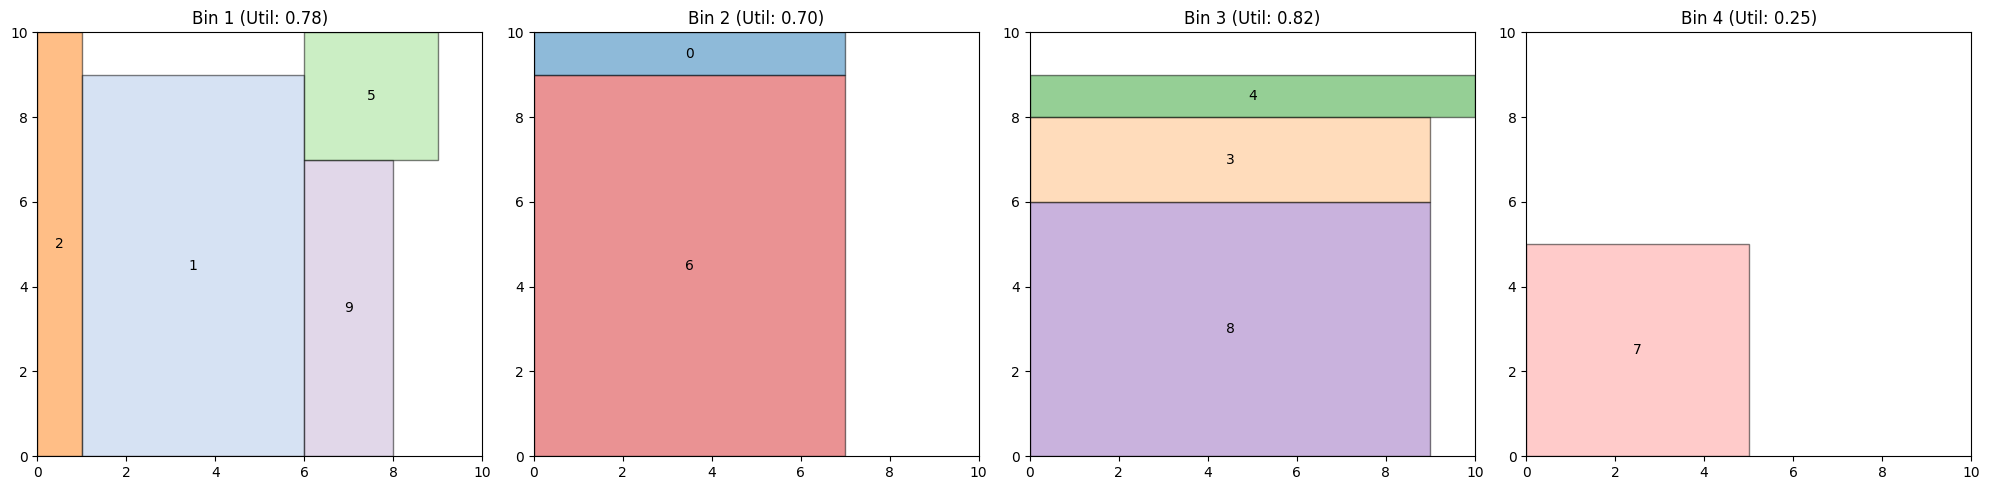


Running Simulated Annealing...
Simulated Annealing: 3 bins


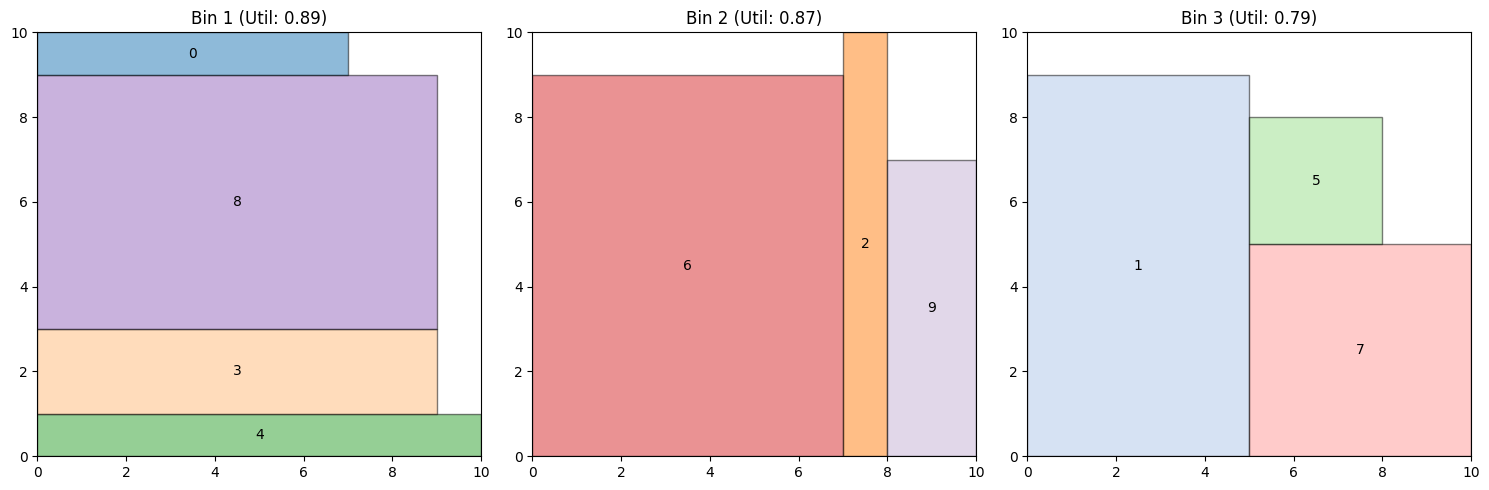


Running Genetic Algorithm...
Simulated Annealing: 3 bins


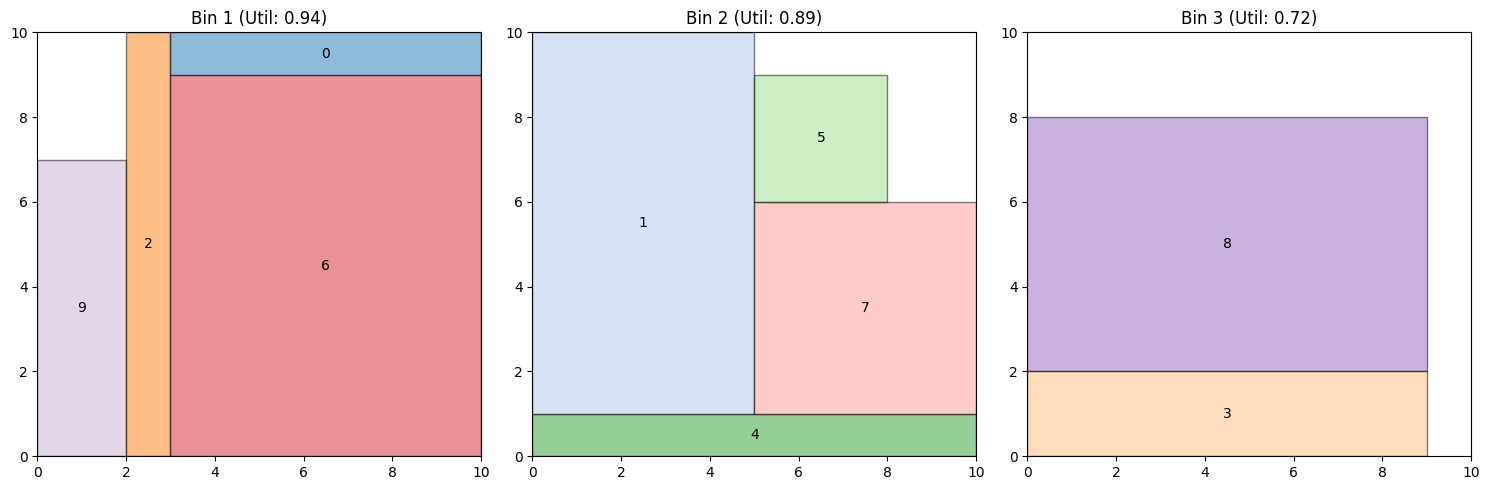


Running Tabu search...
Simulated Annealing: 3 bins


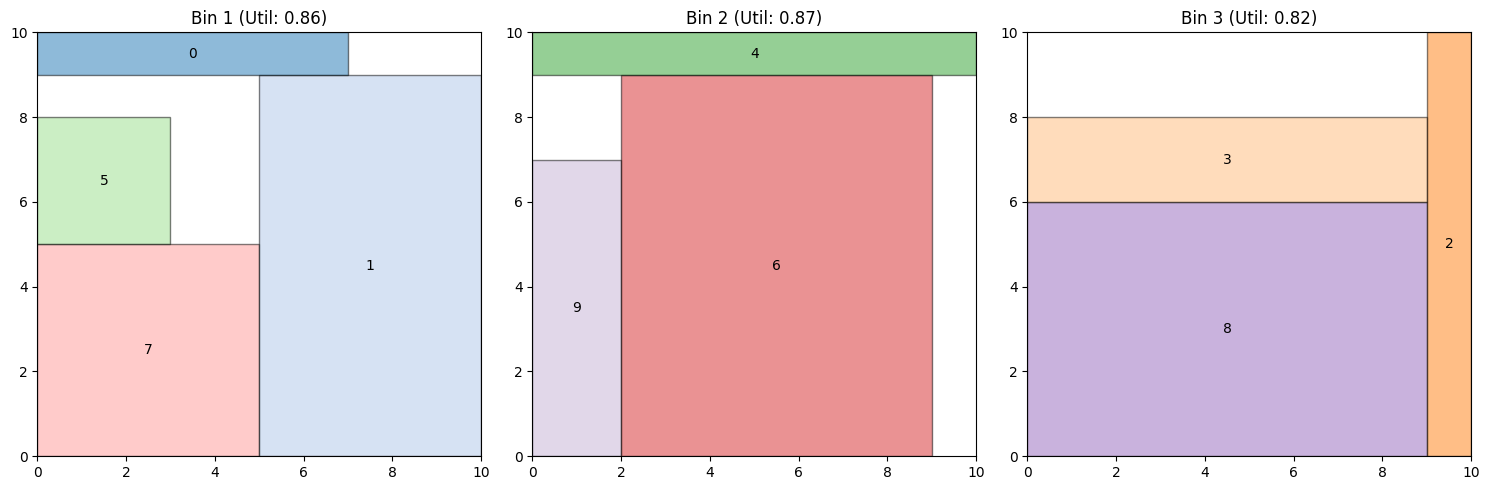


Running Particle Swarm Optimization...
Simulated Annealing: 3 bins


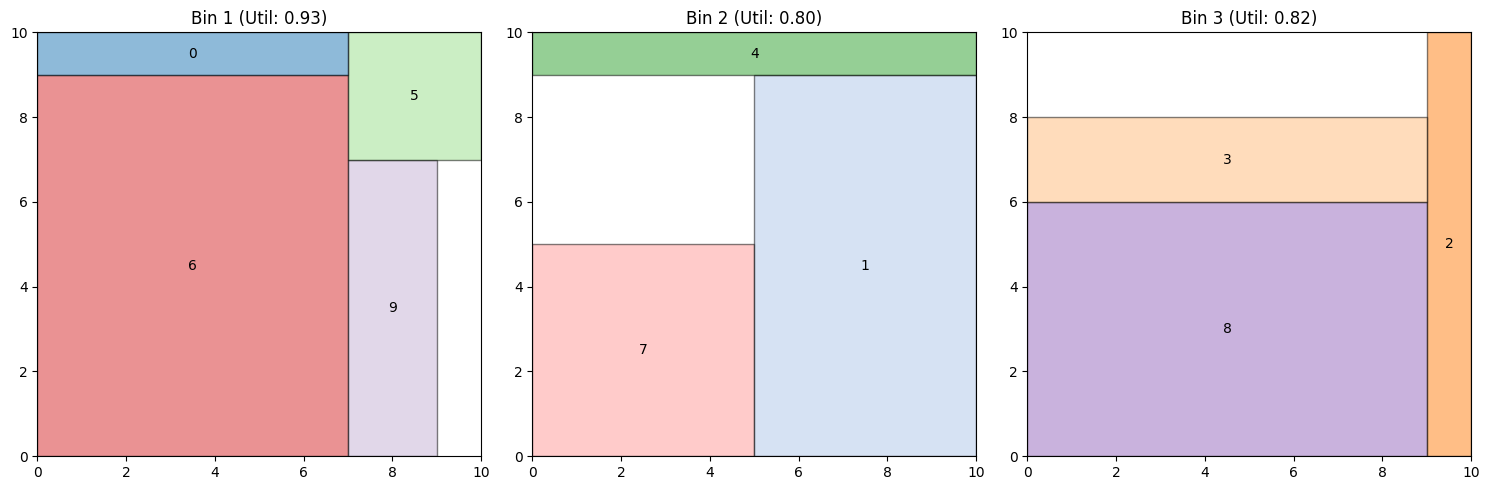


Running Ant Colony Optimization...
Simulated Annealing: 3 bins


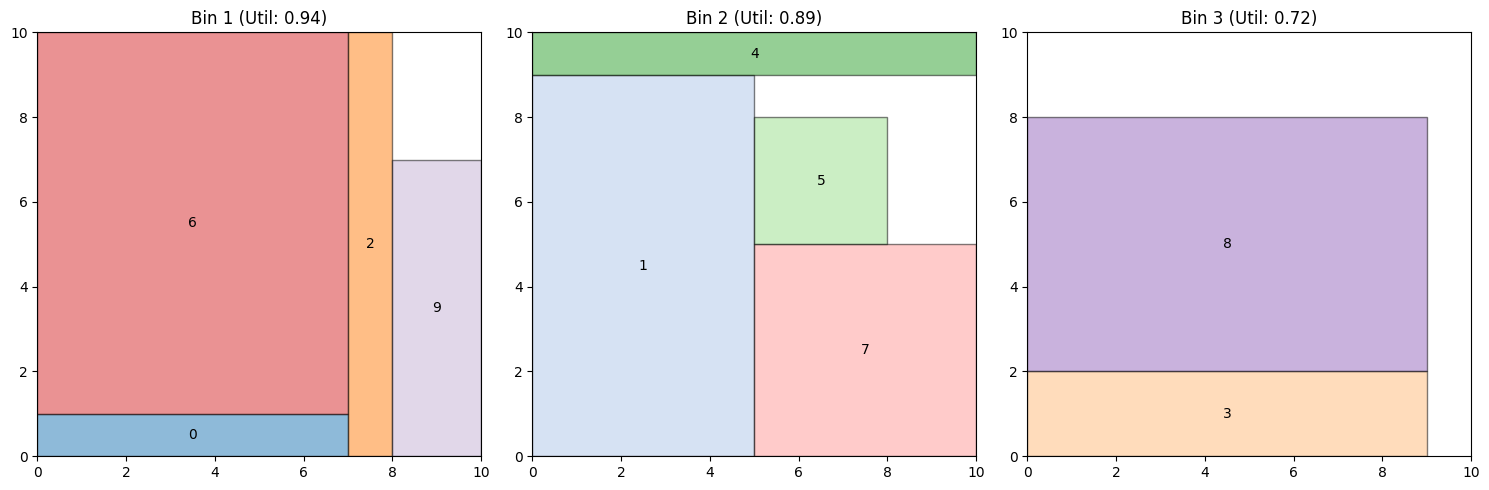

In [ ]:
if __name__ == "__main__":
    # Example usage
    # items = generate_random_items(10)
    bin_width = 10
    bin_height = 10
    print(items)

    print("Running Bottom-Left Fill algorithm...")
    blf_solution = bottom_left_fill(items, bin_width, bin_height)
    print(f"Bottom-Left Fill: {len(blf_solution)} bins")
    visualize_solution(blf_solution)

    # Uncomment to run other algorithms
    print("\nRunning Simulated Annealing...")
    sa_solution = simulated_annealing(items, bin_width, bin_height)
    print(f"Simulated Annealing: {len(sa_solution)} bins")
    visualize_solution(sa_solution)

    # Uncomment to run other algorithms
    print("\nRunning Genetic Algorithm...")
    ga_solution = genetic_algorithm(items, bin_width, bin_height)
    print(f"Simulated Annealing: {len(ga_solution)} bins")
    visualize_solution(ga_solution)

    # Uncomment to run other algorithms
    print("\nRunning Tabu search...")
    tabu_solution = tabu_search(items, bin_width, bin_height)
    print(f"Simulated Annealing: {len(tabu_solution)} bins")
    visualize_solution(tabu_solution)

    # Uncomment to run other algorithms
    print("\nRunning Particle Swarm Optimization...")
    pso_solution = particle_swarm_optimization(items, bin_width, bin_height)
    print(f"Simulated Annealing: {len(pso_solution)} bins")
    visualize_solution(pso_solution)

    # Uncomment to run other algorithms
    print("\nRunning Ant Colony Optimization...")
    aco_solution = ant_colony_optimization(items, bin_width, bin_height)
    print(f"Simulated Annealing: {len(aco_solution)} bins")
    visualize_solution(aco_solution)



In [ ]:
items

[Item(0: 7x1),
 Item(1: 5x9),
 Item(2: 1x10),
 Item(3: 9x2),
 Item(4: 10x1),
 Item(5: 3x3),
 Item(6: 7x9),
 Item(7: 5x5),
 Item(8: 9x6),
 Item(9: 2x7)]